In [1]:
import keras
from keras_self_attention import SeqSelfAttention

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)

In [3]:
data=pd.read_csv("C:/Users/Ruba/Downloads/Authors/AuthorsMerg01.csv",nrows=100000)

In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2283 entries, 0 to 2311
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      2283 non-null   int64 
 1   Text    2283 non-null   object
 2   Author  2283 non-null   object
dtypes: int64(1), object(2)
memory usage: 71.3+ KB


In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [8]:
stop_words = set(stopwords.words('english'))

In [9]:

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [10]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [11]:
cleaned_text[:5]

['project gutenberg ebook complete poetical works edgar allan poe',
 'whatsoever may copy give away use terms',
 'ebook use anyone anywhere united states',
 'parts world cost almost restrictions',
 'whatsoever may copy give away use terms']

In [12]:
#call the function
cleaned_Author = []
for t in data['Author']:
    cleaned_Author.append(text_cleaner(t,1))

In [13]:
cleaned_Author[:10]

['edgar allan poe',
 'agatha christie',
 'edgar allan poe',
 'edgar allan poe',
 'edgar allan poe',
 'edgar allan poe',
 'edgar allan poe',
 'edgar allan poe',
 'edgar allan poe',
 'edgar allan poe']

In [14]:
#restore values of text / Author after cleaning process 
data['cleaned_text']=cleaned_text
data['cleaned_Author']=cleaned_Author

In [15]:
#remove empty spaces and NA ones
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

C:\Users\Ruba\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


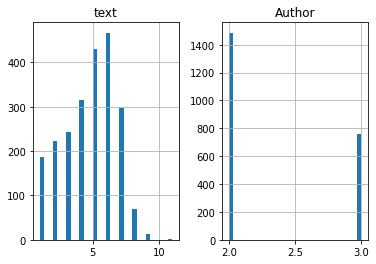

In [16]:

# find the length of sentences in each TEXT / Summay to know the MIN.MAX ranges length
import matplotlib.pyplot as plt

text_word_count = []
Author_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_Author']:
      Author_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'Author':Author_word_count})

length_df.hist(bins = 30)
plt.show()

In [17]:
# limit the length of MAX 
max_text_len=30
max_Author_len=5

In [18]:
# remove the shorter ones than the MAX (max_text_len) limite above
cleaned_text =np.array(data['cleaned_text'])
cleaned_Author=np.array(data['cleaned_Author'])

short_text=[]
short_Author=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_Author[i].split())<=max_Author_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_Author.append(cleaned_Author[i])
        
df=pd.DataFrame({'text':short_text,'Author':short_Author})

In [19]:
# add START and END special tokens (StartTok EndToken)
df['Author'] = df['Author'].apply(lambda x : 'sostok '+ x + ' eostok')

In [20]:
# splitting the data 90/10 using train_test_split function 

import numpy as np
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(np.array(df['text']),np.array(df['Author']),test_size=0.1,random_state=0,shuffle=True)

In [21]:
#Text Tokenizer 

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on x_train data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

In [22]:

# find the least used words by count limit here is 4times
threshold=4 

count=0
tot_count=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_count=tot_count+1
    tot_freq=tot_freq+value
    if(value<threshold):
        count=count+1
        freq=freq+value
    
#print("Number of rare words in vocabulary:",(count/tot_count))
#print("Total Coverage of rare words:",(freq/tot_freq))
# we can remove those words that are used less than specific threshold and count them as rare words

In [23]:
count,tot_count,freq,tot_freq

(3073, 3625, 4158, 9321)

In [24]:
x_tokenizer = Tokenizer(num_words=tot_count-count) 

In [25]:
x_tokenizer

In [26]:
#prepare a tokenizer for reviews on training data
words_count=tot_count-count #6716
x_tokenizer = Tokenizer(num_words=6716) 
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences texts_to_sequences
x_train_seq    =   x_tokenizer.texts_to_sequences(x_train) 
x_test_seq   =   x_tokenizer.texts_to_sequences(x_test)

#post padding  zero upto maximum length to unify the sentences lengths   
x_train    =   pad_sequences(x_train_seq,  maxlen=max_text_len, padding='post')
x_test   =   pad_sequences(x_test_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_vocabulary   =  x_tokenizer.num_words + 1

In [27]:
x_vocabulary,x_test_seq

(6717,
 [[20, 363, 405, 145],
  [444, 1709, 235, 3186, 3187, 531],
  [434],
  [85, 12],
  [972, 3343, 2670, 22, 1681],
  [597, 164, 211, 15],
  [470, 648, 27, 648, 34],
  [361, 831, 1025],
  [702, 11, 8, 3098, 2807],
  [47],
  [80, 686, 121, 254, 303],
  [20, 61, 1046, 45, 42, 832, 1],
  [2151],
  [86, 943, 59],
  [6, 18, 19, 401, 699, 8, 93],
  [60, 75],
  [58, 2900, 10, 18, 53, 223],
  [81, 983, 22, 400, 51, 83, 414],
  [1937, 868, 1132],
  [27, 145, 302],
  [859, 2289, 222],
  [31, 1429, 2853],
  [44, 975],
  [514, 107, 2673, 1131],
  [541],
  [181, 284, 164],
  [2],
  [1359, 93, 8, 151, 154],
  [506, 100, 77, 3454, 2896],
  [140, 1285],
  [54, 264, 36, 515, 169],
  [30],
  [3420],
  [647, 211, 179, 15],
  [303, 27, 215, 2230],
  [145, 496, 145, 3327],
  [388, 22, 1051, 911, 105, 6],
  [801, 290, 374, 21],
  [3197, 1127, 221, 3],
  [117, 192, 3516, 15, 741, 376],
  [556, 821, 27, 622],
  [2438, 2226],
  [43, 341, 412, 175],
  [33, 285],
  [80, 82, 500],
  [1133, 3443, 19],
  [830, 1

In [28]:
#prepare a tokenizer for novels text on training data
#prepare a tokenizer for text by authose on training data
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

In [29]:

# find the least used words by count limit here is 6times for Y

threshold=6

count=0
tot_count=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_count=tot_count+1
    tot_freq=tot_freq+value
    if(value<threshold):
        count=count+1
        freq=freq+value
    
print("number of rare words in vocabulary:",(count/tot_count))
print("Total Coverage of rare words:",(freq/tot_freq))
# we can remove those words that are used less than specific threshold and count them as rare words

number of rare words in vocabulary: 0.0
Total Coverage of rare words: 0.0


In [30]:
words_count=tot_count-count
print(words_count)
# we can remove those words that are used less than specific threshold and count them as rare words

7


In [31]:

words_count=tot_count-count
y_tokenizer = Tokenizer(num_words=words_count) 
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences using texts_to_sequences
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_Author_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_Author_len, padding='post')

#size of vocabulary
y_vocabulary  =   y_tokenizer.num_words +1

In [32]:
# check the length of both train and Y before and after tokanizing , they must be equal 
y_tokenizer.word_counts['sostok'],len(y_train)

(2020, 2020)

In [33]:
from keras import backend as K
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [34]:
import tensorflow as tf 

In [35]:
from keras import backend as K   
latent_dim = 300 # ususally its 300 feature matrix 
embedding_dim=100
 

In [36]:
from tensorflow.keras.layers import Attention
from attention import AttentionLayer
 

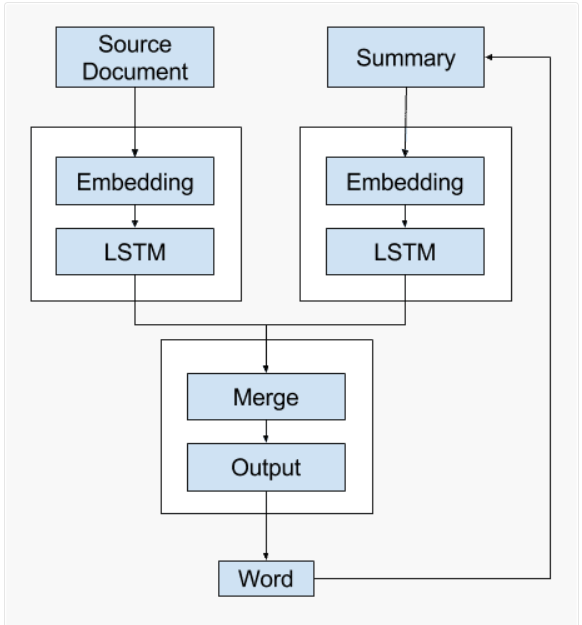

In [37]:
from IPython import display
from IPython.display import Image
PATH = "C:/Users/Ruba/Desktop/Author Detection/"
Image(filename = PATH + "2RecursivemodelRNN.png", width=500, height=500)

In [38]:

##Build Recursive Model :: decoder is given an opportunity to use the previously generated words and the source document
# Encoder encodes it into an internal representation, often a fixed-length vector called the context vector.
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
encoder_emb =  Embedding(x_vocabulary, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1 ,latent_dim = 300
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm1(encoder_emb)


In [39]:
# I tried adding many LSTM but the accuracy wasn't enhanced to I decided to onle keep one layer

In [40]:

#encoder lstm 2
#encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
#encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output1)

#encoder lstm 3
#encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
#encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.



In [41]:

#encoder lstm 2
#encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
#encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output1)

#encoder lstm 3
#encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
#encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#decoder_inputs = Input(shape=(None,))



In [42]:
decoder_inputs = Input(shape=(None,))
#embedding layer
decoder_emb_layer = Embedding(y_vocabulary, embedding_dim,trainable=True)
decoder_emb = decoder_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_emb,initial_state=[state_h, state_c])



In [43]:
# Attention layer class was added manually  
attnention_layer = AttentionLayer(name='attention_layer')



In [44]:
encoder_outputs.shape
decoder_outputs.shape

TensorShape([None, None, 300])

In [45]:
attnention_out, attnention_states = attnention_layer([encoder_outputs, decoder_outputs])


In [46]:
# Concat attention input and decoder LSTM output, since its concatenation the dimention matching is nore vital here
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attnention_out])

In [47]:

#dense layer
decoder_denselayer =  TimeDistributed(Dense(y_vocabulary, activation='softmax'))
# The TimeDistributed wrapper allows the same output layer to be reused for each element in the output sequence.
decoder_outputs = decoder_denselayer(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      671700      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    800         input_2[0][0]                    
______________________________________________________________________________________________

In [48]:
tf.keras.layers.Attention

tensorflow.python.keras.layers.dense_attention.Attention

In [49]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [50]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
es = EarlyStopping(patience=100, monitor='val_loss', restore_best_weights=True) #accuracy, loss, val_loss, val_accuracy

In [51]:
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,
                  epochs=700,callbacks=[es],batch_size=128, 
                  validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/700
16/16 [==============================] - 12s 406ms/step - loss: 1.7829 - val_loss: 0.7843
Epoch 2/700
16/16 [==============================] - 5s 309ms/step - loss: 0.5732 - val_loss: 0.3224
Epoch 3/700
16/16 [==============================] - 5s 311ms/step - loss: 0.2904 - val_loss: 0.2227
Epoch 4/700
16/16 [==============================] - 5s 320ms/step - loss: 0.2030 - val_loss: 0.1707
Epoch 5/700
16/16 [==============================] - 5s 313ms/step - loss: 0.1639 - val_loss: 0.1617
Epoch 6/700
16/16 [==============================] - 5s 309ms/step - loss: 0.1443 - val_loss: 0.1384
Epoch 7/700
16/16 [==============================] - 5s 316ms/step - loss: 0.0949 - val_loss: 0.1179
Epoch 8/700
16/16 [==============================] - 5s 317ms/step - loss: 0.0403 - val_loss: 0.1685
Epoch 9/700
16/16 [==============================] - 5s 312ms/step - loss: 0.0160 - val_loss: 0.1828
Epoch 10/700
16/16 [==============================] - 5s 315ms/step - loss: 0.1028 - val_l

In [52]:
from sklearn.metrics import roc_curve


In [53]:
#from sklearn.metrics import precision_recall_curve
#precision, recall, thresholds = precision_recall_curve(y_test,logreg_train.decision_function(X_test))

In [54]:
#close_zero = np.argmin(np.abs(thresholds))
#plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, 
#label="threshold zero(default)", fillstyle="none", c='k', mew=2)
#plt.plot([0,1], linestyle=' — ', lw=2, color='r', label='random', alpha=0.8)
#plt.legend(loc=4)
#plt.plot(fpr, tpr, label="ROC Curve")
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate (recall)")
#plt.title("roc_curve");
#from sklearn.metrics import auc
#print("AUC score is: ", auc(fpr, tpr));

In [55]:
print(x_train.shape[0]) #2020
print(y_train[:,:-1].shape[0]) #2020
print(y_train.shape[0]) #2020
print(y_train.shape[1]) #5
print(y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:].shape[0]) #2020

print(x_test.shape[0]) #225
print(y_test[:,:-1].shape[0]) #225
print(y_test.shape[0]) #225
print(y_test.shape[1]) #5

2020
2020
2020
5
2020
225
225
225
5


In [56]:
#from sklearn.pipeline import make_pipeline
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import confusion_matrix
#from sklearn.linear_model import LogisticRegression
#logreg = LogisticRegression(class_weight="balanced", random_state=0)
#param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
#grid = GridSearchCV(logreg, param_grid, scoring="roc_auc", cv=5)
#logreg_train = grid.fit([x_train,y_train.shape[1]])

In [57]:
print(y_train.shape[1])
print(x_train.shape[1])

5
30


In [58]:
from tensorflow.keras.utils import to_categorical
#Y_train = to_categorical(y_train)
#Y_test = to_categorical(y_test)
#Y_train=np.concatenate((y_train[:200],y_train[200:225]),axis=0)
Y_train =y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:]#2020,4,1
print(Y_train.shape[1])
Y_train = to_categorical(y_train, 10)

4


In [59]:
y_tokenizer.index_word

{1: 'sostok',
 2: 'eostok',
 3: 'agatha',
 4: 'christie',
 5: 'edgar',
 6: 'allan',
 7: 'poe'}

In [60]:
#x_tokenizer.index_word

In [61]:
np.array(y_tokenizer.index_word)

array({1: 'sostok', 2: 'eostok', 3: 'agatha', 4: 'christie', 5: 'edgar', 6: 'allan', 7: 'poe'},
      dtype=object)

In [62]:
#np.array(x_tokenizer.index_word)

In [63]:
#build the dictionary 
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [64]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

 

In [65]:

# Decoder setup  maps the vector representation back to  target sequence. VEC2Word
# 1. embedding  sequence
# 2. decoder_lstm
# 3.  attnention_layer
# 4. A dense 

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

#   embedding  sequence
decoder_emb2= decoder_emb_layer(decoder_inputs) 
#  set the initial states to the states from the previous time step
decoder_outputs_2, state_h2, state_c2 = decoder_lstm(decoder_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#  attnention_layer
attnention_out_layer, attn_states_inf = attnention_layer([decoder_hidden_state_input, decoder_outputs_2])
decoder_out_concat = Concatenate(axis=-1, name='concat')([decoder_outputs_2, attnention_out_layer])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_denselayer(decoder_out_concat) 

''''
# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_denselayer =  TimeDistributed(Dense(y_vocabulary, activation='softmax'))
decoder_outputs = decoder_denselayer(decoder_concat_input)
'''

#build the Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [66]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    #print(e_out, e_h, e_c)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        #print(output_tokens)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_Author_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [67]:
def seq2Author(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [68]:

#print("Predicted Author:",decode_sequence(x_train))
#print(encoder_model.predict(x_train[:10]))

True labels count 1915
False labels count 105
True labels Percent 94.80198019801979 %


Accuracy:  0.948019801980198
Precision:  0.9462345679707227
Recall:  0.9363068822203438
F1:  0.9409946778367831


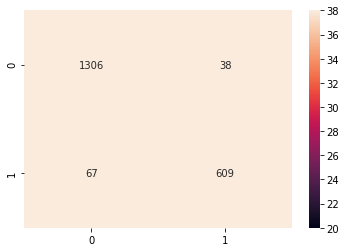

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
_Correct = 0
_InCorrect = 0
Y_test=[]
Y_array=[]

for i in range(0,2020):
    #"True label Author:" 
    Y_test.append(seq2Author(y_train[i]).strip())
    
    ##"Predicted Author:"
    Y_array.append(decode_sequence(x_train[i].reshape(1,max_text_len)).strip())
    #print("Original Author:",seq2summary(y_train[i]).strip())
    #print("Predicted  Author:",decode_sequence(x_train[i].reshape(1,max_text_len)).strip())   
    if (decode_sequence(x_train[i].reshape(1,max_text_len)).strip() == seq2Author(y_train[i]).strip()):
        _Correct +=1
    else:
        _InCorrect+=1
   # print("\n")

print("True labels count", _Correct)
print("False labels count", _InCorrect)
FinalRestults= (_Correct/(_Correct+_InCorrect) ) * 100
print("True labels Percent" ,FinalRestults ,"%" )
print("\n")

# prdicted author VS True label Author
conf=confusion_matrix(Y_test,Y_array)
#conf=confusion_matrix(Y_test, Y_array)

sns.heatmap(conf, annot=True, fmt='d', vmax=20)   

preds = (Y_array)  
     
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: ", accuracy_score(Y_test, preds))
print("Precision: ", precision_score(Y_test, preds, average='macro'),)
print("Recall: ", recall_score(Y_test, preds, average='macro'))
print("F1: ", f1_score(Y_test, preds, average='macro'))

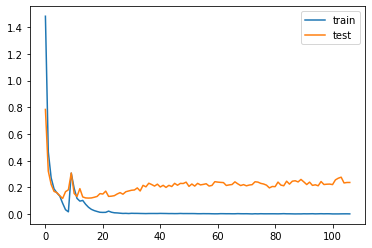

In [75]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [740]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=1)